<a href="https://colab.research.google.com/github/omerhac/arc_challenge/blob/master/arc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import json
from google.cloud import storage
from matplotlib import pyplot as plt
from matplotlib import colors

# Load data


In [0]:
## get paths
GCS_PATH = "gs://kds-d3cfb3d523ca35d2517017a78110126404d01fdea69417ce49950459"
training_filenames = tf.io.gfile.glob(GCS_PATH + "/training/*")
test_filenames = tf.io.gfile.glob(GCS_PATH + "/test/*")
eval_filenames = tf.io.gfile.glob(GCS_PATH + "/evaluation/*")

In [3]:
%%time
# create datasets with filenames
training_dataset = tf.data.Dataset.list_files(training_filenames)
eval_dataset = tf.data.Dataset.list_files(eval_filenames)
test_dataset = tf.data.Dataset.list_files(test_filenames)

CPU times: user 8.72 s, sys: 593 ms, total: 9.31 s
Wall time: 3min 13s


In [0]:
# load the jsons
def load_task(filename):
  task_json = tf.io.read_file(filename)
  return task_json

training_dataset = training_dataset.map(load_task)
eval_dataset = eval_dataset.map(load_task)
test_dataset = test_dataset.map(load_task)

training_dataset_numpy = tf.data.Dataset.as_numpy_iterator(training_dataset, num_parallel_calls=AUTO) # convert to numpy iterator
eval_dataset_numpy = tf.data.Dataset.as_numpy_iterator(eval_dataset)
test_dataset_numpy = tf.data.Dataset.as_numpy_iterator(test_dataset)


In [5]:
%%time
## create a numpy array of tasks (n_tasks, )
def array_from_jsons(jsons_numpy_iterator):
  """
    Create an array of task dictionaries from jsons numpy interator
  """

  tasks = []
  for task in jsons_numpy_iterator:
    tasks.append(json.loads(task))

  return np.stack(tasks)

## get numpy arrays of datasets
training_tasks = array_from_jsons(training_dataset_numpy)
eval_tasks = array_from_jsons(eval_dataset_numpy)
test_tasks = array_from_jsons(test_dataset_numpy)

CPU times: user 12.7 s, sys: 839 ms, total: 13.5 s
Wall time: 8min 16s


## Utility functions

In [0]:
def plot_board(board, ax):
  """
  Plot a board on a given axis
  """
  cmap = colors.ListedColormap(
      ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
  norm = colors.Normalize(vmin=0, vmax=9)
  
  ax.imshow(board, cmap=cmap, norm=norm)
  ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
  ax.set_yticks([x-0.5 for x in range(1+board.shape[0])])
  ax.set_xticks([x-0.5 for x in range(1+board.shape[1])])     
  ax.set_xticklabels([])
  ax.set_yticklabels([])


def plot_one(task, ax, i,train_or_test,input_or_output):
  """
  Plot one task on a given axis
  """
  cmap = colors.ListedColormap(
      ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
  norm = colors.Normalize(vmin=0, vmax=9)
  
  input_matrix = task[train_or_test][i][input_or_output]
  ax.imshow(input_matrix, cmap=cmap, norm=norm)
  ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
  ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
  ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_title(train_or_test + ' '+input_or_output)
    

def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i],i,'train','input')
        plot_one(task, axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(task, axs[0],0,'test','input')
        plot_one(task, axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(axs[0,i],i,'test','input')
            plot_one(axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show() 

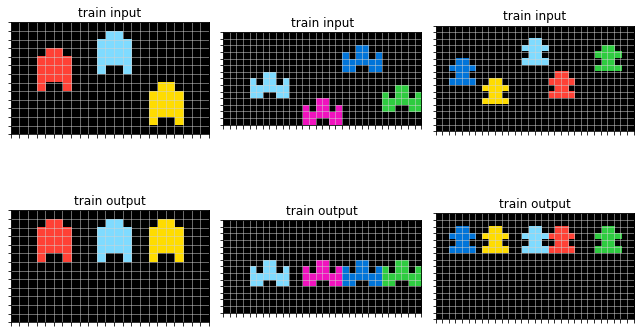

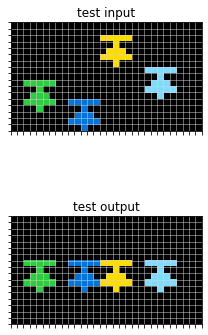

In [0]:
plot_task(eval_tasks[1])

# Check input / output shape distirbution

In [0]:
def get_dataset_shapes(dataset):
  """
  Returns dataset board shapes. 
  """

  shape_0 = []
  shape_1 = []
  
  # check every task
  for task in dataset:
    boards = get_task_boards(task) # get all boards
    shape_0 += [board.shape[0] for board in boards]
    shape_1 += [board.shape[1] for board in boards]
  
  return shape_0, shape_1

def get_task_boards(task, threshold_shape=(np.inf, np.inf), pad=None, test=False):
  """
  Get the training / testing boards of every example in a specific task. 

  Args: threshold_shape --> threshold shape for which 
  biggger samples won't be returned. 
  pad --> functional padding function to pad boards with (up tp threshold_size).
  test --> bool, whether a test task or not. for output of task example.
  """
  
  boards = []

  # train boards
  for example in task['train']:
    input_board = np.array(example['input'])
    output_board = np.array(example['output'])

    if((input_board.shape[0] < threshold_shape[0]) and (input_board.shape[1] < threshold_shape[1])):
      boards.append(pad(input_board, output_shape=threshold_shape) if pad else input_board) # check for padding func

    if((output_board.shape[0] < threshold_shape[0]) and (output_board.shape[1] < threshold_shape[1])):
      boards.append(pad(output_board, output_shape=threshold_shape) if pad else output_board) # check for padding func

  # test boards
  for example in task['test']:
    input_board = np.array(example['input'])

    if not test: # check if test example
      output_board = np.array(example['output'])
    
    # check whether the board is smaller then threshold shape
    if((input_board.shape[0] < threshold_shape[0]) and (input_board.shape[1] < threshold_shape[1])):
      boards.append(pad(input_board, output_shape=threshold_shape) if pad else input_board) # check for padding func

    if((output_board.shape[0] < threshold_shape[0]) and (output_board.shape[1] < threshold_shape[1]) and (not test)):
      boards.append(pad(output_board, output_shape=threshold_shape) if pad else output_board) # check for padding func

  return boards

def pad(mat, output_shape, padder=0):
  """
  Pad a matrix with padder up to output_shape.
  
  Args:
  mat - np.array matrix of rank 2
  output_shape - tuple 
  padder - int
  """

  output_board = np.zeros(shape=output_shape) + padder # create output board and pad it

  # get input shape
  input_rows = mat.shape[0]
  input_cols = mat.shape[1]

  # insert input matrix in upper left corner
  output_board[:input_rows, :input_cols] = mat
  return output_board

In [0]:
train_shape_0, train_shape_1 = get_dataset_shapes(training_tasks)
eval_shape_0, eval_shape_1 = get_dataset_shapes(eval_tasks)

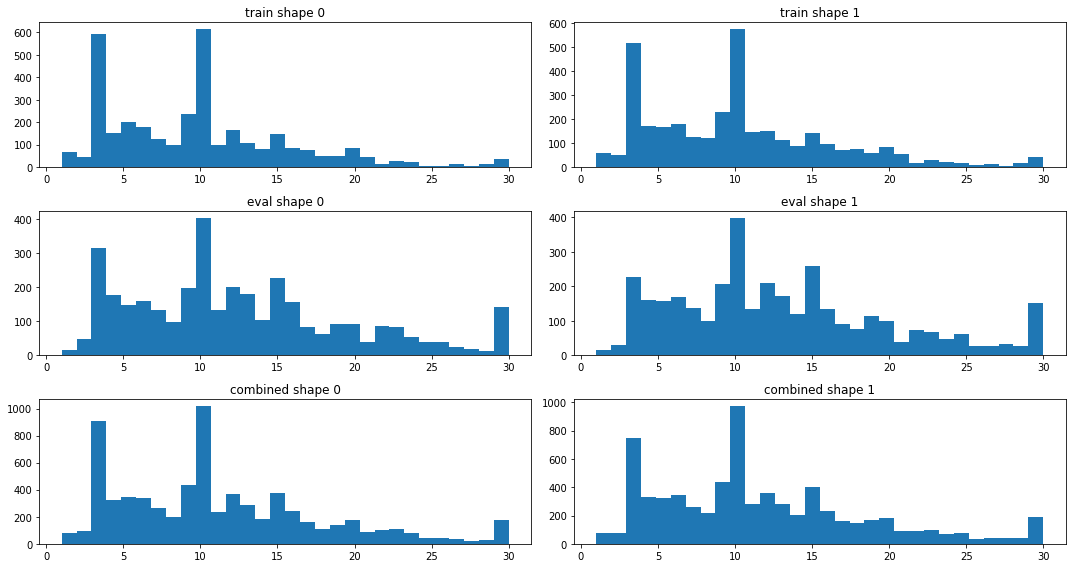

In [119]:
## plot
plt.figure(figsize=(15,8))
plt.subplot(3,2,1)
plt.hist(train_shape_0, bins=30)
plt.title("train shape 0")
plt.subplot(3,2,2)
plt.hist(train_shape_1, bins=30)
plt.title("train shape 1")
plt.subplot(3,2,3)
plt.hist(eval_shape_0, bins=30)
plt.title("eval shape 0")
plt.subplot(3,2,4)
plt.hist(eval_shape_1, bins=30)
plt.title("eval shape 1")
plt.subplot(3,2,5)
plt.hist(eval_shape_0 + train_shape_0, bins=30)
plt.title("combined shape 0")
plt.subplot(3,2,6)
plt.hist(eval_shape_1 + train_shape_1, bins=30)
plt.title("combined shape 1")
plt.tight_layout()
plt.show()

## Prepare data for learning pattern features

In [0]:
BOARD_SIZE = (15,15) # board upperbound size

# get all boards
training_boards = []
for task in training_tasks:
  training_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=pad)

eval_boards = []
for task in eval_tasks:
  eval_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=pad)

test_boards = []
for task in test_tasks:
  test_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=pad, test=True)

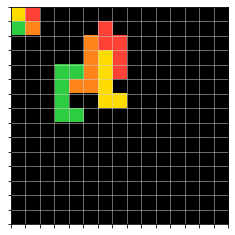

In [141]:
fig, ax = plt.subplots(1,1)
plot_board(test_boards[1], ax)